In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()
(digit_x_train, digit_y_train), (digit_x_test, digit_y_test) = tf.keras.datasets.mnist.load_data()

fashion_x_train = fashion_x_train.reshape((-1, 28, 28, 1))/255
fashion_x_test = fashion_x_test.reshape((-1, 28, 28, 1))/255
digit_x_train = digit_x_train.reshape((-1, 28, 28, 1))/255
digit_x_test = digit_x_test.reshape((-1, 28, 28, 1))/255

fashion_y_train = fashion_y_train.reshape(-1, 1)
fashion_y_test = fashion_y_test.reshape(-1, 1)
digit_y_train = digit_y_train.reshape(-1, 1)
digit_y_test = digit_y_test.reshape(-1, 1)

fashion_x_train_output = fashion_x_train.reshape((fashion_x_train.shape[0], -1))
fashion_x_test_output = fashion_x_test.reshape((fashion_x_test.shape[0], -1))
digit_x_train_output = digit_x_train.reshape((digit_x_train.shape[0], -1))
digit_x_test_output = digit_x_test.reshape((digit_x_test.shape[0], -1))

In [3]:
input_layer = tf.keras.layers.Input(fashion_x_train.shape[1:])
main_x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input_layer)
main_x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.MaxPool2D(strides = 1, padding = 'valid')(main_x)

ood_x = tf.keras.layers.Flatten()(main_x)
ood_x = tf.keras.layers.Dense(100, activation = 'relu')(ood_x)

main_x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(main_x)
main_x = tf.keras.layers.MaxPool2D(strides = 1, padding = 'valid')(main_x)

branch_x = tf.keras.layers.Flatten()(main_x)
ood_x = tf.keras.layers.Concatenate()([ood_x, branch_x])
ood_x = tf.keras.layers.Dense(100, activation = 'relu')(ood_x)

main_x = tf.keras.layers.Flatten()(main_x)
main_x = tf.keras.layers.Dense(100, activation = 'relu')(main_x)
main_output = tf.keras.layers.Dense(10, activation = 'softmax')(main_x)

ood_x = tf.keras.layers.Concatenate()([ood_x, main_x])
ood_output = tf.keras.layers.Dense(28 * 28, activation = 'sigmoid')(ood_x)

model = tf.keras.models.Model(input_layer, [main_output, ood_output])
model.compile(
    loss = ['sparse_categorical_crossentropy', 'cosine_similarity'],
    optimizer = 'adam'
)

Metal device set to: Apple M1


2021-10-29 10:43:24.238663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-29 10:43:24.238766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 27, 27, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3, restore_best_weights = True)
model.fit(
    fashion_x_train,
    [fashion_y_train, fashion_x_train_output],
    epochs = 100,
    batch_size = 512,
    validation_split = 0.2,
    callbacks = [callback]
)

2021-10-29 10:43:24.630348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 10:43:24.630547: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-10-29 10:43:24.837502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: -0.3499 - dense_3_loss: 0.5182 - dense_4_loss: -0.8681

2021-10-29 10:43:49.347904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 27s 283ms/step - loss: -0.3499 - dense_3_loss: 0.5182 - dense_4_loss: -0.8681 - val_loss: -0.5746 - val_dense_3_loss: 0.3495 - val_dense_4_loss: -0.9242
Epoch 2/100
94/94 [==============================] - 23s 243ms/step - loss: -0.6294 - dense_3_loss: 0.3099 - dense_4_loss: -0.9392 - val_loss: -0.6487 - val_dense_3_loss: 0.3019 - val_dense_4_loss: -0.9506
Epoch 3/100
94/94 [==============================] - 19s 206ms/step - loss: -0.6980 - dense_3_loss: 0.2581 - dense_4_loss: -0.9561 - val_loss: -0.6938 - val_dense_3_loss: 0.2671 - val_dense_4_loss: -0.9609
Epoch 4/100
94/94 [==============================] - 19s 203ms/step - loss: -0.7449 - dense_3_loss: 0.2186 - dense_4_loss: -0.9635 - val_loss: -0.7093 - val_dense_3_loss: 0.2561 - val_dense_4_loss: -0.9653
Epoch 5/100
94/94 [==============================] - 19s 197ms/step - loss: -0.7797 - dense_3_loss: 0.1872 - dense_4_loss: -0.9669 - val_loss: -0.7103 - val_dense_3_loss: 0.2576 - val_dens

In [6]:
preds, autoencode = model.predict(fashion_x_test)
test_similarities = tf.keras.losses.cosine_similarity(fashion_x_test_output.astype('float32'), autoencode.astype('float32'))
in_domain_similarities = test_similarities.numpy()
preds = preds.argmax(axis = 1)

2021-10-29 10:45:23.141710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [7]:
threshold = in_domain_similarities.mean() + 1.5*in_domain_similarities.std()

In [8]:
print(classification_report(fashion_y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.85      0.84      0.84      1000
           3       0.85      0.93      0.89      1000
           4       0.84      0.84      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.75      0.70      0.73      1000
           7       0.95      0.94      0.94      1000
           8       0.98      0.97      0.98      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



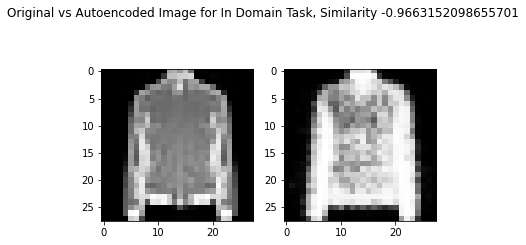

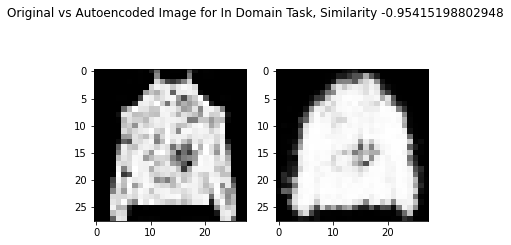

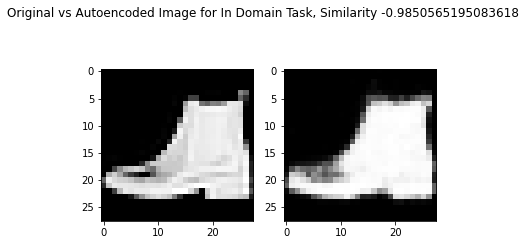

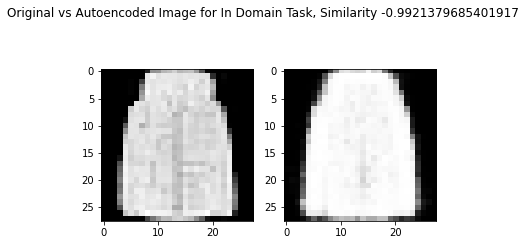

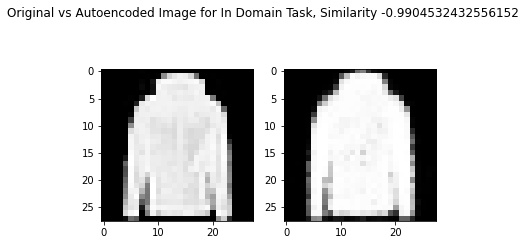

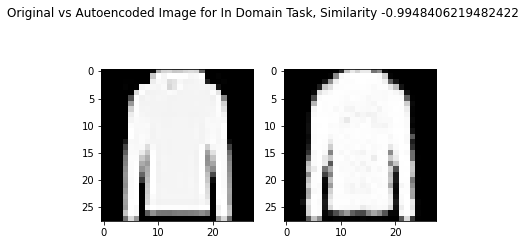

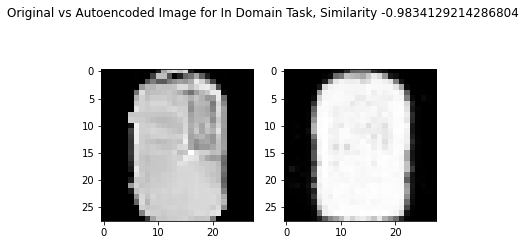

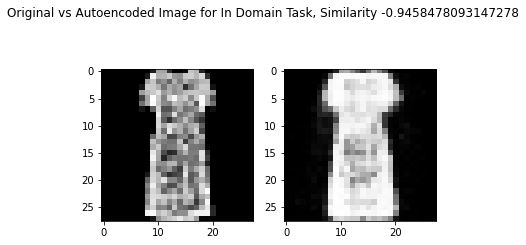

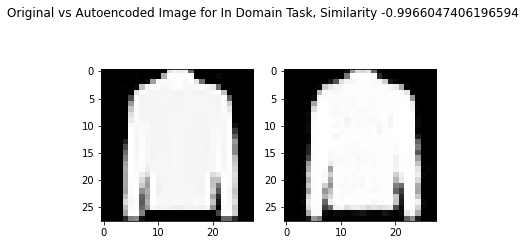

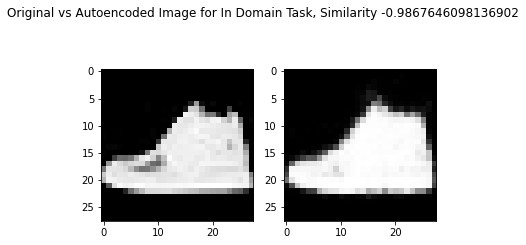

In [9]:
for random_index in np.random.choice(np.arange(preds.shape[0]), 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image for In Domain Task, Similarity {in_domain_similarities[random_index]}')
    ax1.imshow(fashion_x_test[random_index], cmap = 'Greys_r')
    ax2.imshow(autoencode[random_index].reshape((28, 28, 1)), cmap = 'Greys_r')
    plt.show()

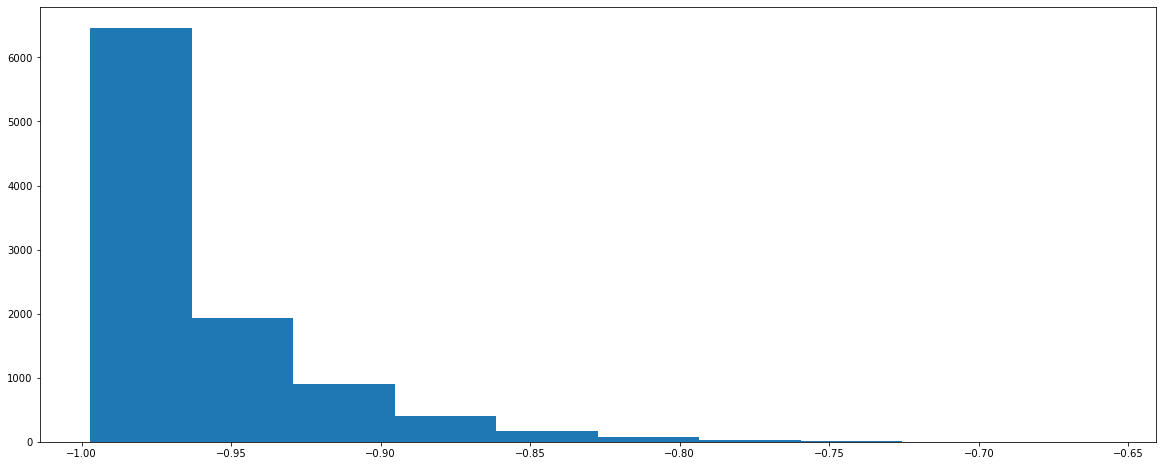

In [10]:
plt.figure(figsize = (20, 8))
plt.hist(in_domain_similarities)
plt.show()

In [11]:
preds, autoencode = model.predict(digit_x_test)
test_similarities = tf.keras.losses.cosine_similarity(digit_x_test_output.astype('float32'), autoencode)
ood_similarities = test_similarities.numpy()
preds = preds.argmax(axis = 1)

In [12]:
print(classification_report(digit_y_test, preds))

              precision    recall  f1-score   support

           0       0.01      0.02      0.01       980
           1       0.22      0.14      0.17      1135
           2       0.01      0.01      0.01      1032
           3       0.19      0.09      0.12      1010
           4       0.00      0.00      0.00       982
           5       0.16      0.64      0.26       892
           6       0.13      0.01      0.01       958
           7       0.02      0.02      0.02      1028
           8       0.05      0.07      0.06       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.09     10000
   macro avg       0.08      0.10      0.07     10000
weighted avg       0.08      0.09      0.07     10000



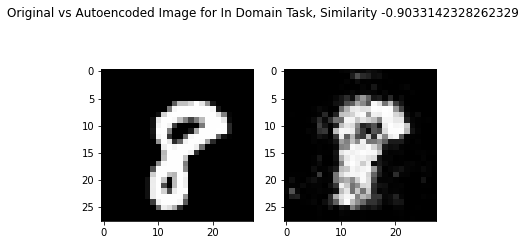

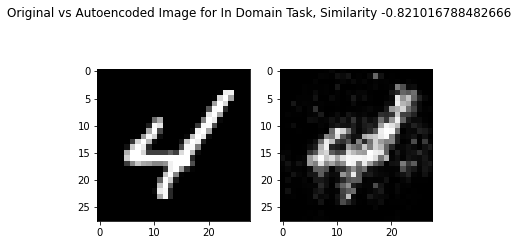

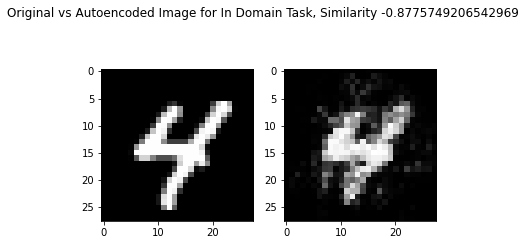

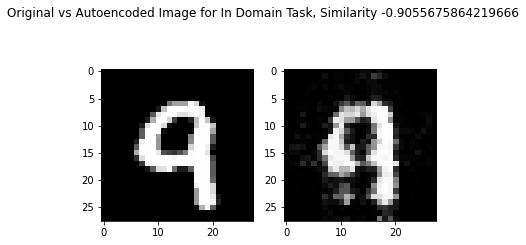

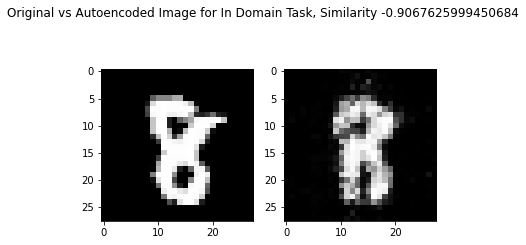

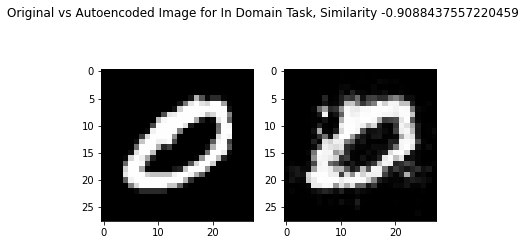

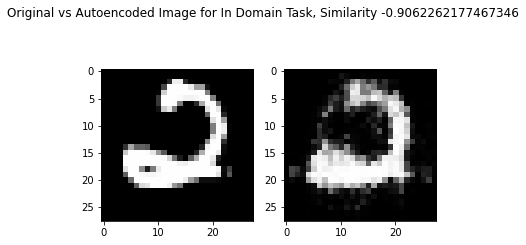

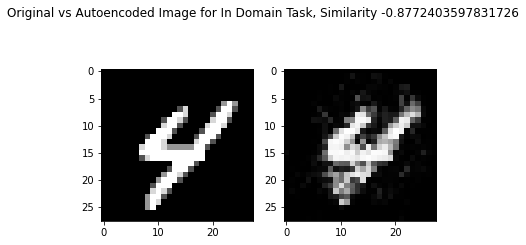

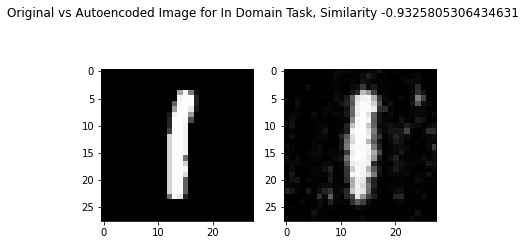

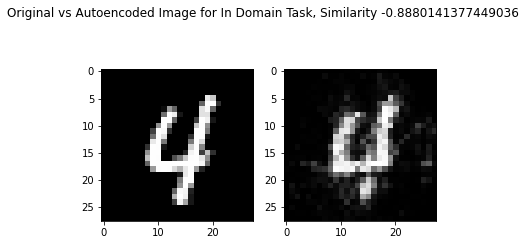

In [13]:
for random_index in np.random.choice(np.arange(preds.shape[0]), 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image for In Domain Task, Similarity {ood_similarities[random_index]}')
    ax1.imshow(digit_x_test[random_index], cmap = 'Greys_r')
    ax2.imshow(autoencode[random_index].reshape((28, 28, 1)), cmap = 'Greys_r')
    plt.show()

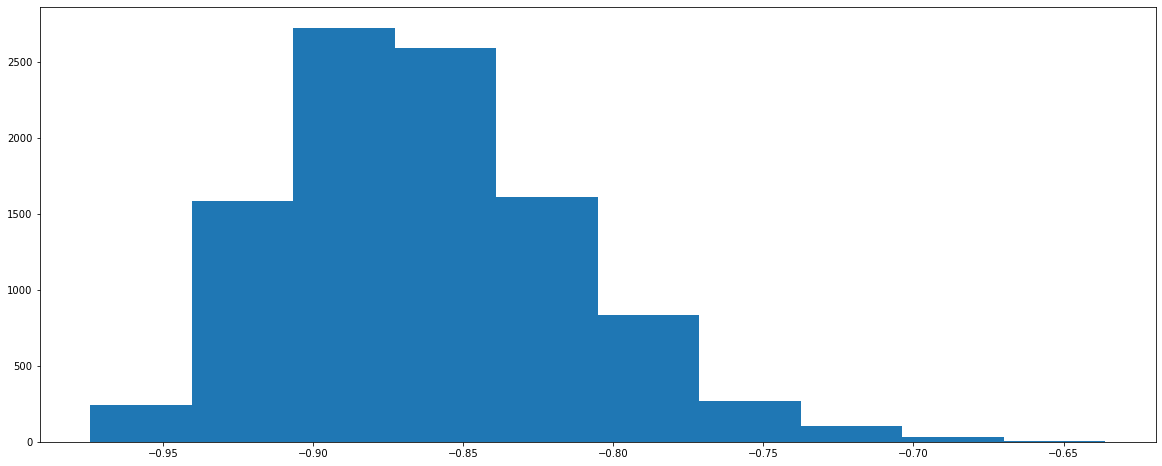

In [14]:
plt.figure(figsize = (20, 8))
plt.hist(ood_similarities)
plt.show()

In [15]:
ood_trust = ood_similarities <= threshold
pd.Series(ood_trust).value_counts()

False    8008
True     1992
dtype: int64

In [16]:
wild_images = os.listdir('wild_images/')
images = [cv2.imread(os.path.join('wild_images', file)) for file in wild_images]
wild_images = np.asarray(images)
wild_images = tf.image.rgb_to_grayscale(wild_images).numpy()

In [17]:
wild_preds, wild_autoencode = model.predict(wild_images)
wild_similarities = tf.keras.losses.cosine_similarity(wild_images.astype('float32').reshape(wild_autoencode.shape[0], 784), wild_autoencode.astype('float32')).numpy()

2021-10-29 10:45:29.579032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


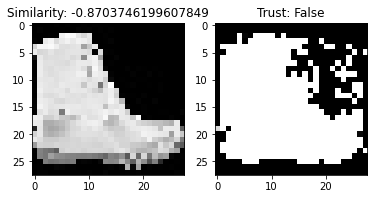

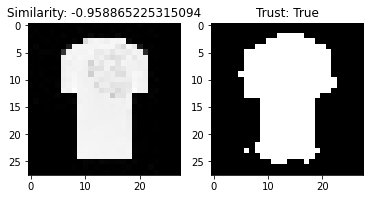

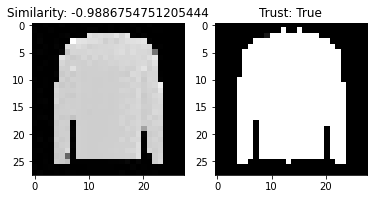

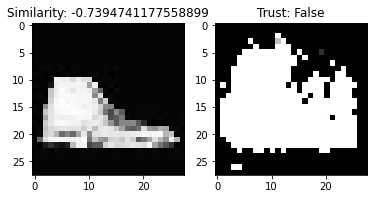

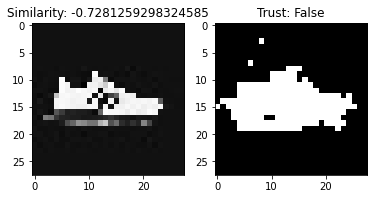

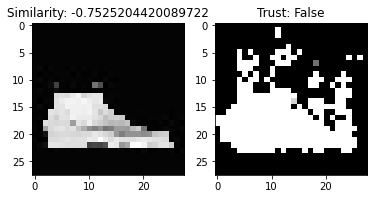

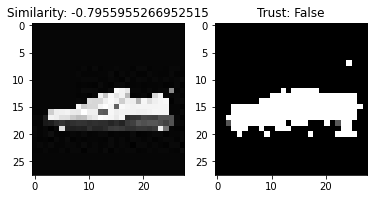

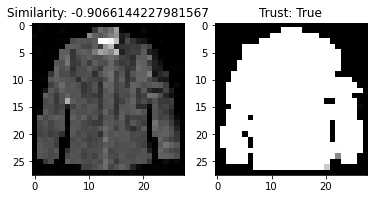

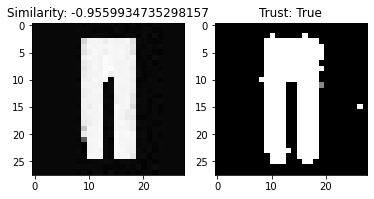

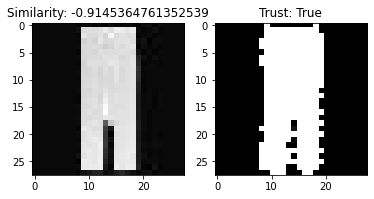

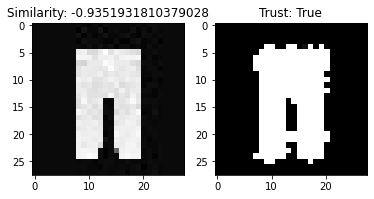

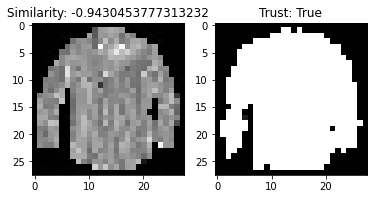

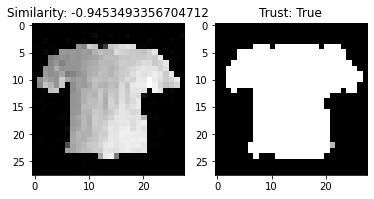

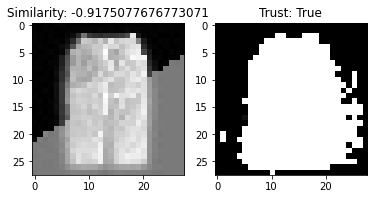

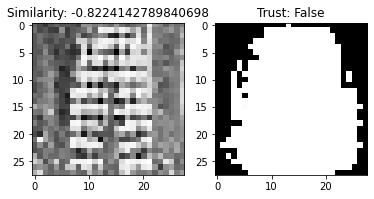

In [18]:
for i in range(wild_autoencode.shape[0]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(wild_images[i], cmap = 'Greys_r')
    ax2.imshow(wild_autoencode[i].reshape(28, 28), cmap = 'Greys_r')
    ax1.set_title(f'Similarity: {wild_similarities[i]}')
    ax2.set_title(f'Trust: {wild_similarities[i] < threshold}')
    plt.show()